In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import sys
sys.path.append('../scripts')
from paths import SIMULATED_PATH
from models import NaiveModel
from simulated_data import NaiveDataGenerator, NaiveCrowdsourcingDataGenerator, ACTIONS
from experiments import PretrainedProbe
from omegaconf import OmegaConf
from sklearn.metrics import average_precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/naive_batch-size-1024/.hydra/config.yaml')
cfg.model.batch_size = 16
cfg

{'model': {'name': 'naive', 'hidden_width': 128, 'discount_factor': 0.85, 'input_width': 90, 'output_width': 60, 'sampling_rate': 1, 'stride': 30, 'batch_size': 16}, 'patience': 5}

In [16]:
gen = NaiveCrowdsourcingDataGenerator(cfg)

In [17]:
direct_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(ACTIONS), activation='sigmoid')
])
direct_model(next(iter(gen.train))[0])
direct_model.load_weights(f'{SIMULATED_PATH}/outputs/direct.h5')

In [19]:
linear_classifier = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(cfg.model.hidden_width, activation='relu'),
    tf.keras.layers.Dense(len(ACTIONS), activation='sigmoid')
])
linear_classifier(next(iter(gen.train))[0])
linear_classifier.load_weights(f'{SIMULATED_PATH}/outputs/linear_classifier.h5')

In [20]:
model = NaiveModel(cfg)
model_gen = NaiveDataGenerator(cfg)
model(next(iter(model_gen.train))[0])
model.load_weights(f'{SIMULATED_PATH}/outputs/naive_batch-size-1024/weights.h5')
pretrained_probe = PretrainedProbe(cfg, model)
pretrained_probe(next(iter(gen.train))[0])
pretrained_probe.load_weights(f'{SIMULATED_PATH}/outputs/pretrained_probe.h5')

In [25]:
true_labels = {k: [] for k in ACTIONS}
direct_model_predictions = {k: [] for k in ACTIONS}
linear_classifier_predictions = {k: [] for k in ACTIONS}
pretrained_model_predictions = {k: [] for k in ACTIONS}
for x_batch, y_batch in gen.test:
    y_batch = y_batch.numpy()
    direct_pred = direct_model(x_batch).numpy()
    linear_classifier_pred = linear_classifier(x_batch).numpy()
    pretrained_probe_pred = pretrained_probe(x_batch).numpy()
    for y, y_direct, y_linear, y_pretrained in zip(y_batch, direct_pred, linear_classifier_pred, pretrained_probe_pred):
        for i, action in enumerate(ACTIONS):
            if y[i] == -1:
                continue
            true_labels[action].append(y[i])
            direct_model_predictions[action].append(y_direct[i])
            linear_classifier_predictions[action].append(y_linear[i])
            pretrained_model_predictions[action].append(y_pretrained[i])
for labels in [true_labels, direct_model_predictions, linear_classifier_predictions, pretrained_model_predictions]:
    labels = {k: np.array(v) for k, v in labels.items()}

In [52]:
df = []
for action in ACTIONS:
    for model, predictions in zip(['direct prediction', 'linear classifier', 'pretrained probe'], 
                                  [direct_model_predictions, linear_classifier_predictions, pretrained_model_predictions]):
        df.append({
            'action': action,
            'model': model,
            'average precision': average_precision_score(true_labels[action], predictions[action]),
            'f1_macro': f1_score(true_labels[action], np.round(predictions[action]), average='macro'),
            'f1_micro': f1_score(true_labels[action], np.round(predictions[action]), average='micro')
        })
df = pd.DataFrame(df)
df

,action,model,average precision,f1_macro,f1_micro
0,hit,direct prediction,0.845227,0.470588,0.888889
1,hit,linear classifier,0.909574,0.467456,0.877778
2,hit,pretrained probe,0.932741,0.690189,0.911111
3,slap,direct prediction,0.553322,0.496081,0.611111
4,slap,linear classifier,0.526385,0.509269,0.611111
...,...,...,...,...,...
67,tip,linear classifier,0.791040,0.857870,0.900000
68,tip,pretrained probe,0.806780,0.812890,0.877778
69,tumble,direct prediction,0.614071,0.699198,0.777778
70,tumble,linear classifier,0.592096,0.699198,0.777778


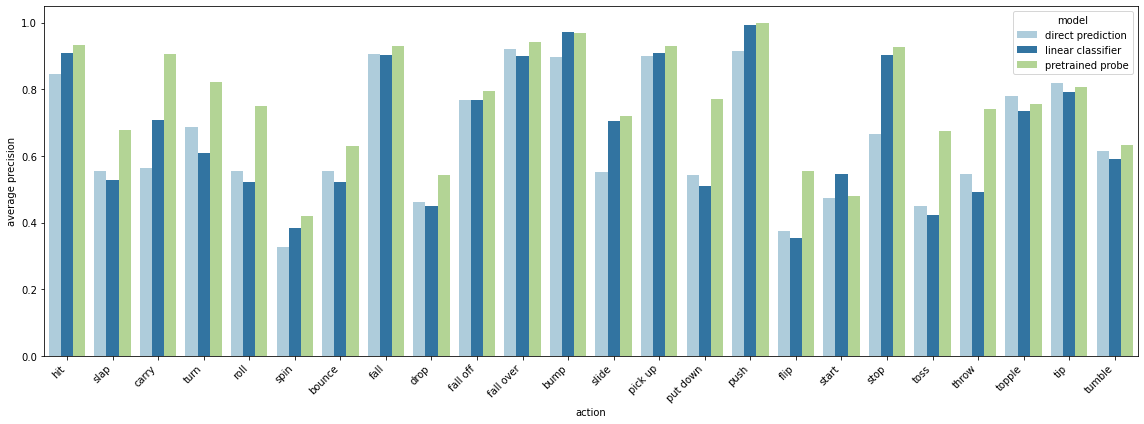

In [55]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=45, ha='right')
sns.barplot(data=df, x='action', y='average precision', hue='model', palette='Paired')
plt.tight_layout()
plt.savefig(f'{SIMULATED_PATH}/docs/results.png')